In [1]:
import sys
import os
import warnings
import pandas as pd
import numpy as np

# Add the root directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('weld_quality_prediction'), '..')))

from data_preprocessing.functions import replace_data, choose_labels, pipeline_training_set
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('../data/welddb.data', sep=' ', header=None)

column_names = [
    "Carbon_concentration",
    "Silicon_concentration",
    "Manganese_concentration",
    "Sulphur_concentration",
    "Phosphorus_concentration",
    "Nickel_concentration",
    "Chromium_concentration",
    "Molybdenum_concentration",
    "Vanadium_concentration",
    "Copper_concentration",
    "Cobalt_concentration",
    "Tungsten_concentration",
    "Oxygen_concentration",
    "Titanium_concentration",
    "Nitrogen_concentration",
    "Aluminium_concentration",
    "Boron_concentration",
    "Niobium_concentration",
    "Tin_concentration",
    "Arsenic_concentration",
    "Antimony_concentration",
    "Current",
    "Voltage",
    "AC_or_DC",
    "Electrode_positive_or_negative",
    "Heat_input",
    "Interpass_temperature",
    "Type_of_weld",
    "Post_weld_heat_treatment_temperature",
    "Post_weld_heat_treatment_time",
    "Yield_strength",
    "Ultimate_tensile_strength",
    "Elongation",
    "Reduction_of_Area",
    "Charpy_temperature",
    "Charpy_impact_toughness",
    "Hardness",
    "50%_FATT",
    "Primary_ferrite_in_microstructure",
    "Ferrite_with_second_phase",
    "Acicular_ferrite",
    "Martensite",
    "Ferrite_with_carbide_aggregate",
    "Weld_ID"
]

sulphur_and_phosphorus_columns = ["Sulphur_concentration","Phosphorus_concentration"]

other_concentration_columns = ["Carbon_concentration",
        "Silicon_concentration",
        "Manganese_concentration",
        "Nickel_concentration",
        "Chromium_concentration",
        "Molybdenum_concentration",
        "Vanadium_concentration",
        "Copper_concentration",
        "Cobalt_concentration",
        "Tungsten_concentration",
        "Oxygen_concentration",
        "Titanium_concentration",
        "Nitrogen_concentration",
        'Nitrogen_concentration_residual',
        "Aluminium_concentration",
        "Boron_concentration",
        "Niobium_concentration",
        "Tin_concentration",
        "Arsenic_concentration",
        "Antimony_concentration"]

label_names = ['Yield_strength', 'Ultimate_tensile_strength', 'Elongation', 'Reduction_of_Area', 'Charpy_temperature', 
                   'Charpy_impact_toughness', 'Hardness', '50%_FATT', 'Primary_ferrite_in_microstructure', 'Ferrite_with_second_phase', 
                   'Acicular_ferrite', 'Martensite', 'Ferrite_with_carbide_aggregate', 'Hardness_load']

physical_ordinal_properties_columns = [
        'Current', 
        'Voltage',
        'Heat_input',
        'Interpass_temperature',
        'Post_weld_heat_treatment_temperature',
        'Post_weld_heat_treatment_time', 
    ]

physical_categorical_properties_columns = [
    'AC_or_DC',
    'Electrode_positive_or_negative',
    'Type_of_weld'
]

data.columns = column_names

In [3]:
# Suppress all FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Selection of the targets
labels_selected = ["Yield_strength"]

#Replace 'N' value with Nan
data = replace_data(data)

#Selection fof the data for supervised learning
data_with_label = data.copy()
data_with_label = data[data_with_label[labels_selected].notna().all(axis=1)]

#Separation of features and labels
X, y = choose_labels(data_with_label, labels_chosen=labels_selected)


# Linear Regression

## Finding best hyperparameters with grid Search 
Training, Validation and Test Set

In [12]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

# Grid Search
pca_percent_explained_variances = [0.8, 0.85, 0.9]

best_model = None
best_score = float('inf')
best_pca_percent_explained_variance = None

# K-Cross Validation
for pca_percent_explained_variance in pca_percent_explained_variances:
    current_X_train, current_X_test, current_y_train, current_y_test = pipeline_training_set(training_set=X_train, training_labels=y_train, testing_set=X_test, testing_labels=y_test, 
                                                             labels_chosen=labels_selected, categorical_strategy="logistic", \
                                                            ordinal_strategy="linear", is_PCA=True, pca_percent_explained_variance=pca_percent_explained_variance, 
                                                            scaler_strategy="normalizer", pca_columns="all_ordinals", less_than_strategy="mean")
    reg = LinearRegression()
    scores = cross_val_score(reg, current_X_train, current_y_train, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    score = rmse_scores.mean()
    print("\n Mean Scores: ", score, "\n")
    if score < best_score:
        best_score = score
        best_model = reg
        best_pca_percent_explained_variance = pca_percent_explained_variance

Number of components chosen by PCA: 3
Explained Variance Ratio: [0.3951825  0.33907527 0.07457294]

 Mean Scores:  85.13372602119684 

Number of components chosen by PCA: 4
Explained Variance Ratio: [0.39527361 0.33923974 0.07455471 0.05843857]

 Mean Scores:  84.9895689145184 

Number of components chosen by PCA: 5
Explained Variance Ratio: [0.39527361 0.33923974 0.07455471 0.05843857 0.04948367]

 Mean Scores:  85.0440235343323 



## Best hyperparameters for linear regression 

- pca_percent_explained_variance = 0.85

- scaler_strategy = normalizer

- Number of components chosen by PCA: 4

- Validation MSE = 84.9895689145184

- Perf on unseen data (mse) = 98.29864758226721

<div class="alert alert-block alert-success">
<b> Explanation </b>

- Using PCA approach help getting rid of outliers

- Choosing a normalizer strategy keeps the variance of each feature while standardising them might loose it.
More PCA components will then be computed for a standard strategy compared to a normalizer strategy 
which does not help reducing the dimension of the dataset.

- categorical_strategy, ordinal_strategy, less_than_strategy do not have any influence on the validation set 

</div>

In [10]:
new_X_train, new_X_test, new_y_train, new_y_test = pipeline_training_set(training_set=X_train, training_labels=y_train, testing_set=X_test, testing_labels=y_test, 
                                                             labels_chosen=labels_selected, categorical_strategy="logistic", \
                                                            ordinal_strategy="linear", is_PCA=True, pca_percent_explained_variance=best_pca_percent_explained_variance, 
                                                            scaler_strategy="normalizer", pca_columns="all_ordinals", less_than_strategy="mean")

best_model.fit(new_X_train, new_y_train)
y_pred = best_model.predict(new_X_test)
mse = np.sqrt(mean_squared_error(new_y_test, y_pred))
print("\nmse: ", mse)

Number of components chosen by PCA: 4
Explained Variance Ratio: [0.39527361 0.33923974 0.07455471 0.05843857]

 mse:  98.29864758226721


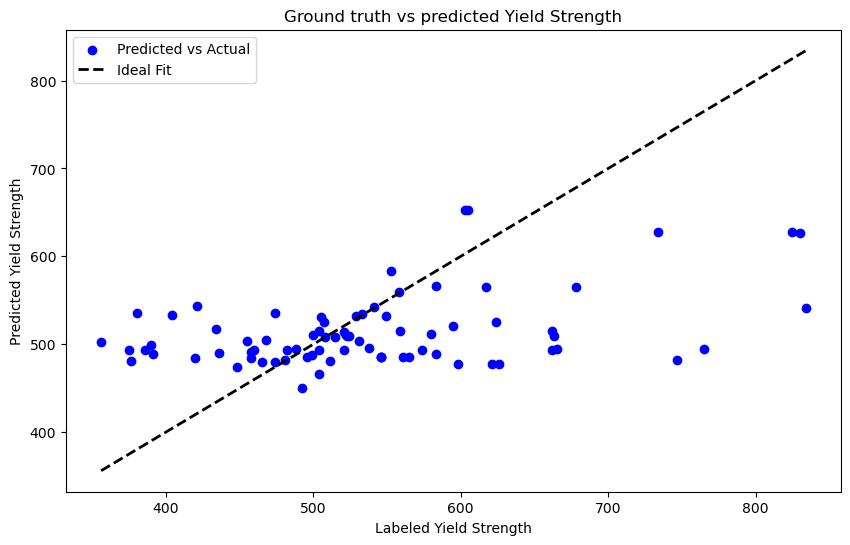

In [9]:
import matplotlib.pyplot as plt

# Convert new_y_test to a numpy array for plotting
new_y_test_values = new_y_test.values.astype(float)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(new_y_test_values, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([new_y_test_values.min(), new_y_test_values.max()], [new_y_test_values.min(), new_y_test_values.max()], 'k--', lw=2, label='Ideal Fit')
plt.xlabel('Labeled Yield Strength')
plt.ylabel('Predicted Yield Strength')
plt.title('Ground truth vs predicted Yield Strength')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">

Linear Regression is probably not the best approach for this problem 
</div>